# Project overview

- Aim: find the properties are most likely to increase in the following 5 yeras in Victoria.

# Data Resource

Property data: scraped data from the domian website.

API features: School, librbary, gym, supermarket, train station, CDB, supermrket, police station. Using Open Street Servious
 to get the latitude and longitude.

Poplulation, median weekly income, SA2: download from ABS (Australian Bureau of Statistics) website 

Crime: scraped data from the Victoria crime statistic website.

Postcode: from Github

# Data Preprocessing

## Property data

First look over the raw data to ensure the information it contains. We started  to :
- drop the useless columns.
- remove the car park parks and the rent price below 200 weekly ones in order to ensure the price is reasonable
- get the postcode of each property and standardize the price into weekly price, in order to make the follow-up work easier. 
- dropping the empty values and duplicates in address we divided the whole property into 4 parts to reduce time for the future work.

The graph of the data to see the inner features relationship with price:
- positive correlation between price and beds, price and baths, price and parking
- negative correlation between postcode and price

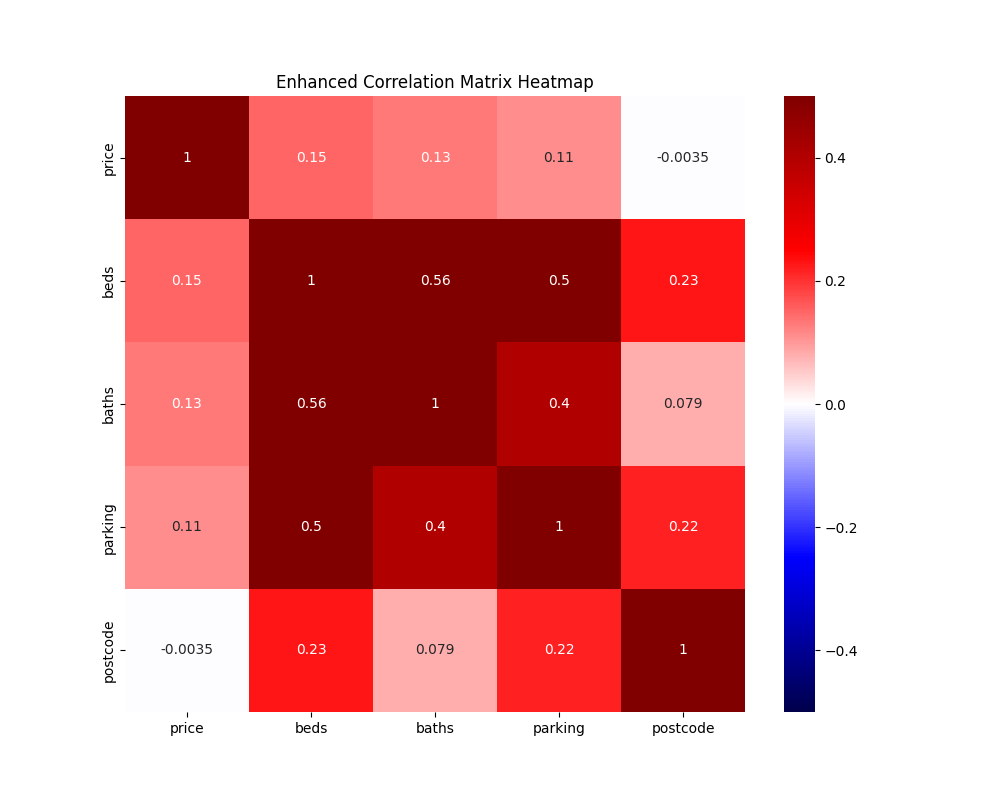

In [3]:
from IPython.display import Image

Image("plots/heatmap_inner.png")

## Externel data

Population and income:
- selected the columns: popluation from 2021-2023, SA2 code, SA2 name, median weekly income, oversea immigrations, population changes and Population density per region form 2 different dataset.
- combine 2 dataset on SA2 code
- drop the empty value and drop duplicated on SA2 code ones

School:
- remove the 'Postal_Town' column and group by 'Address_Postcode', summing the number of schools for each postcode

API features:
- drop the latitude and longitude empty ones

Crime:
- get 2021,2022,2023 year's crime then group the data by Postcode and Year to get the total crime count

Historical price:
- get all the suburb name, date and average rent price from the history price dataset
- merge with the selected Victoria postcode data based on the suburb name for some suburbs we manually corrected.

# Feature engineering

API: calculate driving distances between houses and nearby key facilities by using OpenRouteService API. We created a distance matrix for each of them, making sure to get the shortest driving distance then processed the coordinates in batches to found the closest facilities. Saving the shortest distance into a new csv file.

Popluation: plot the graph to see the outliers to determine the further steps need to do. Also we plot the maps by SA2 region to display the overall distribution of weekly income and overseas immigration.
Also we calculate the population by postcode for the modeling.

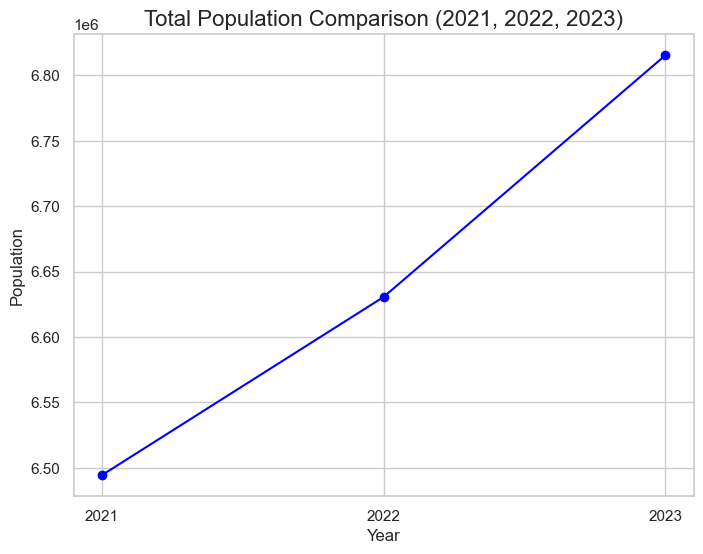

In [2]:
from IPython.display import Image

Image("plots/population.png")

The popluation has the increase trendency

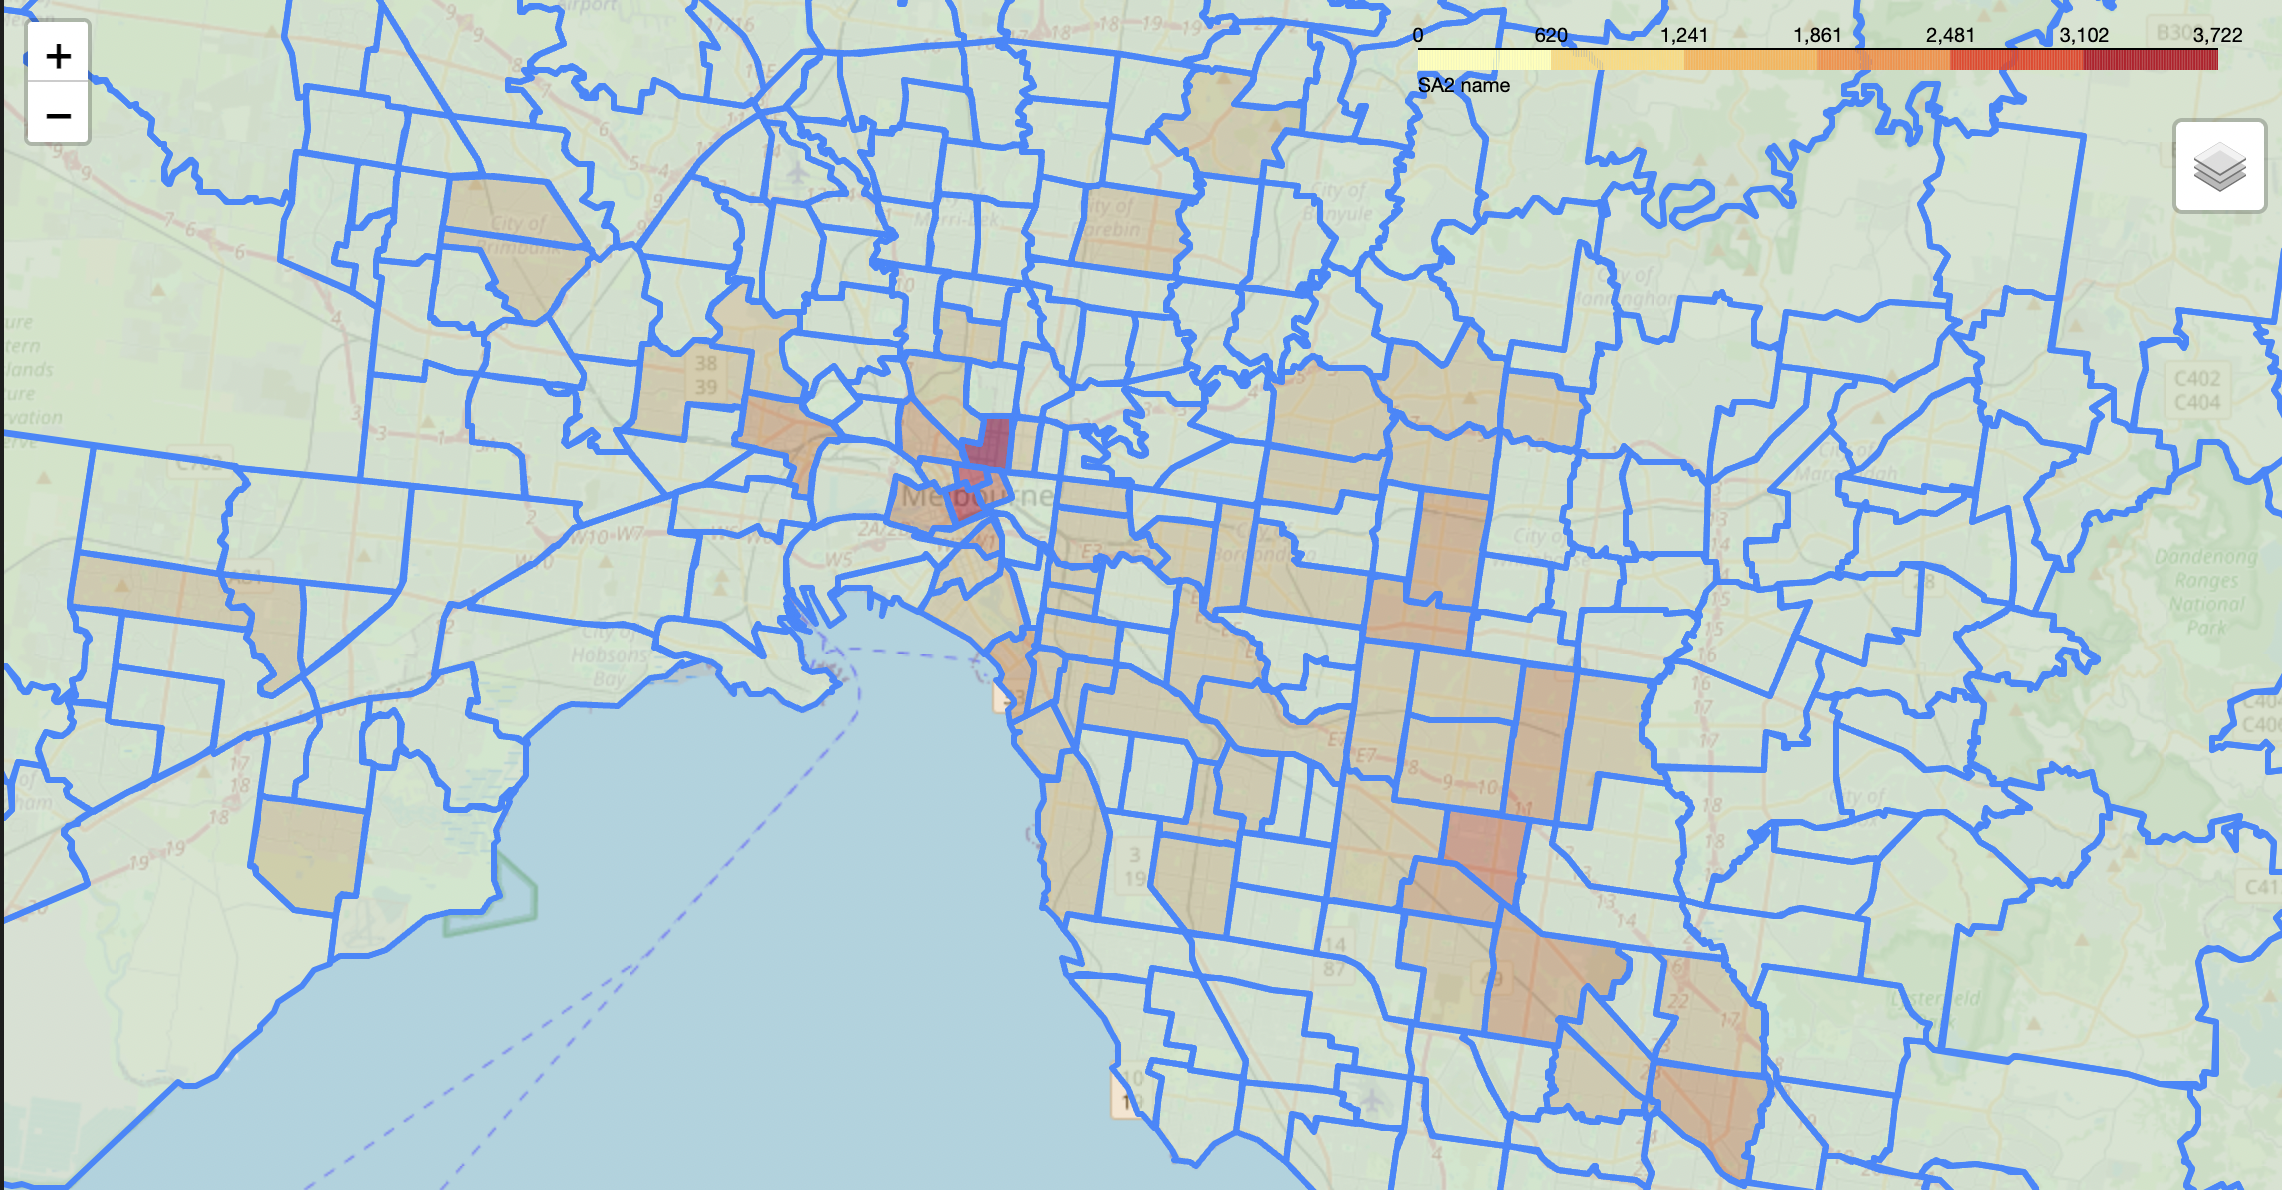

In [3]:
Image("plots/overseas.png")

The overseas immgration is more dispersed, more people may consider the suburbs which is far from CBD

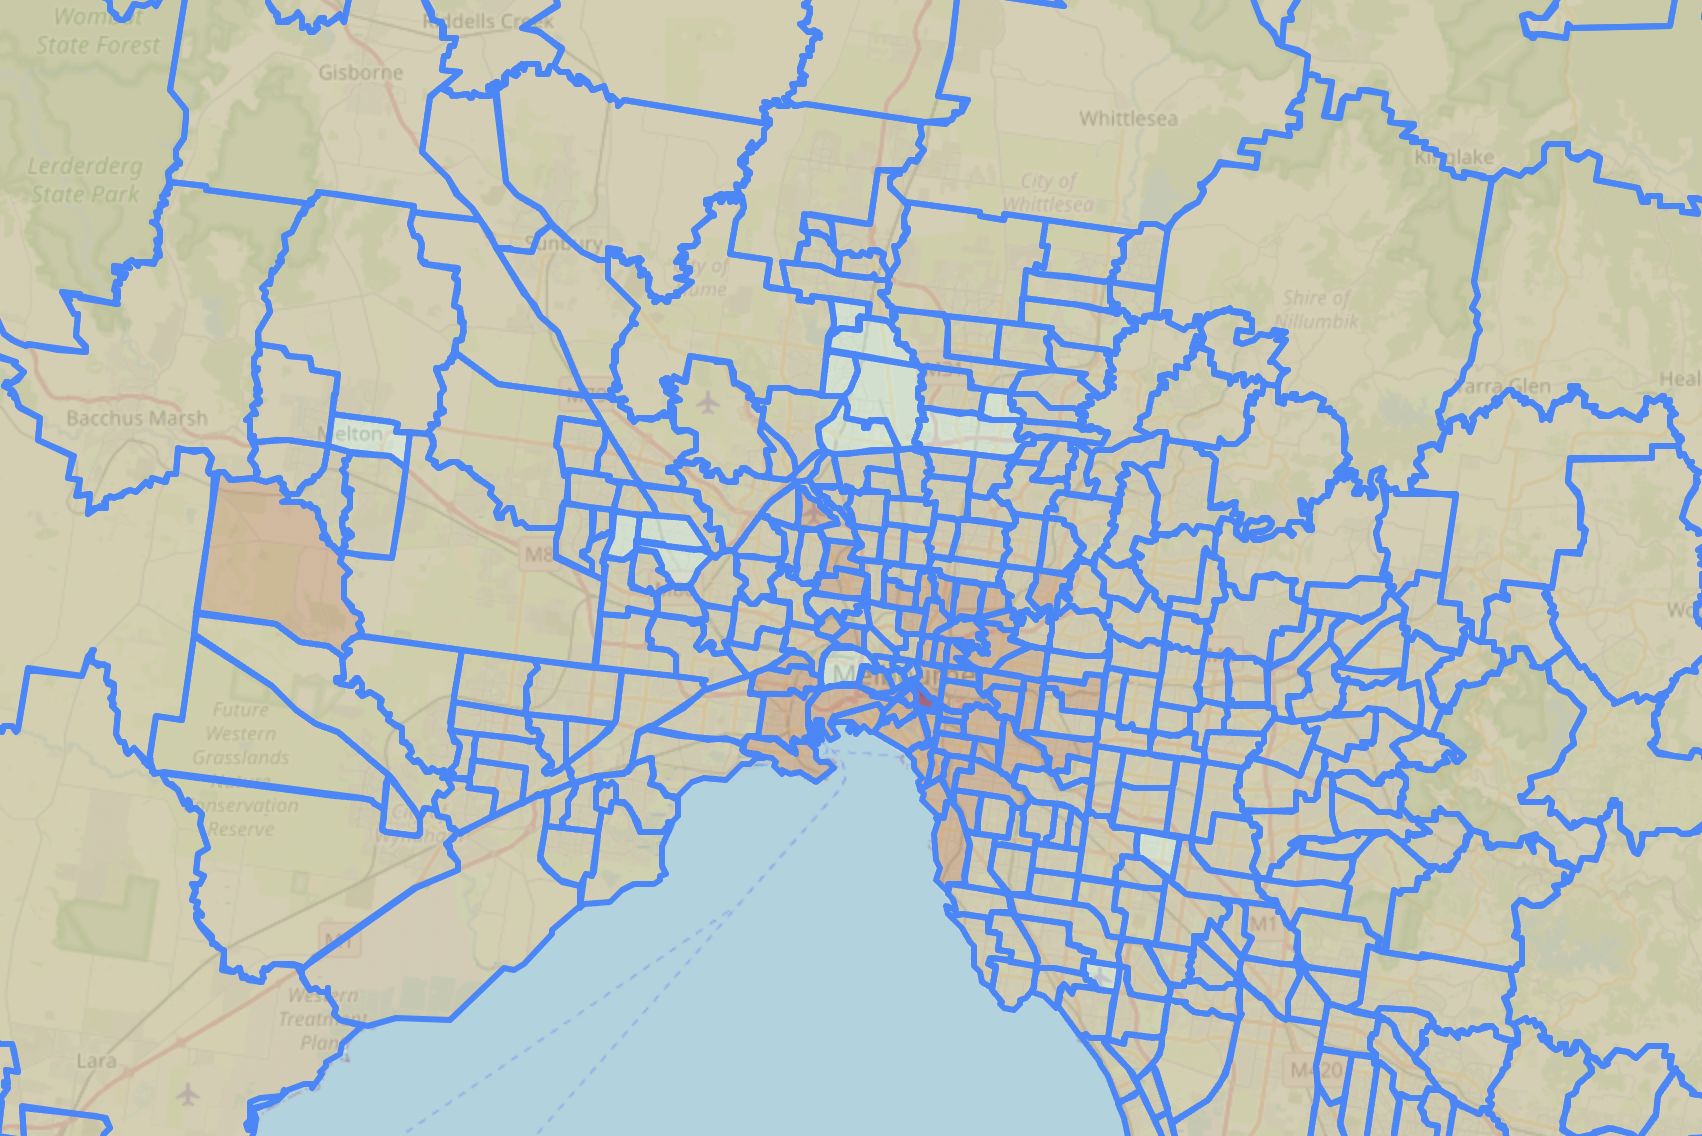

In [4]:
Image("plots/income.png")

The higher weekly income is concerated to CBD.

Crime: the pie chart uses 200 offences as a cut-off point to observe the overall percentage of of crime counts. 

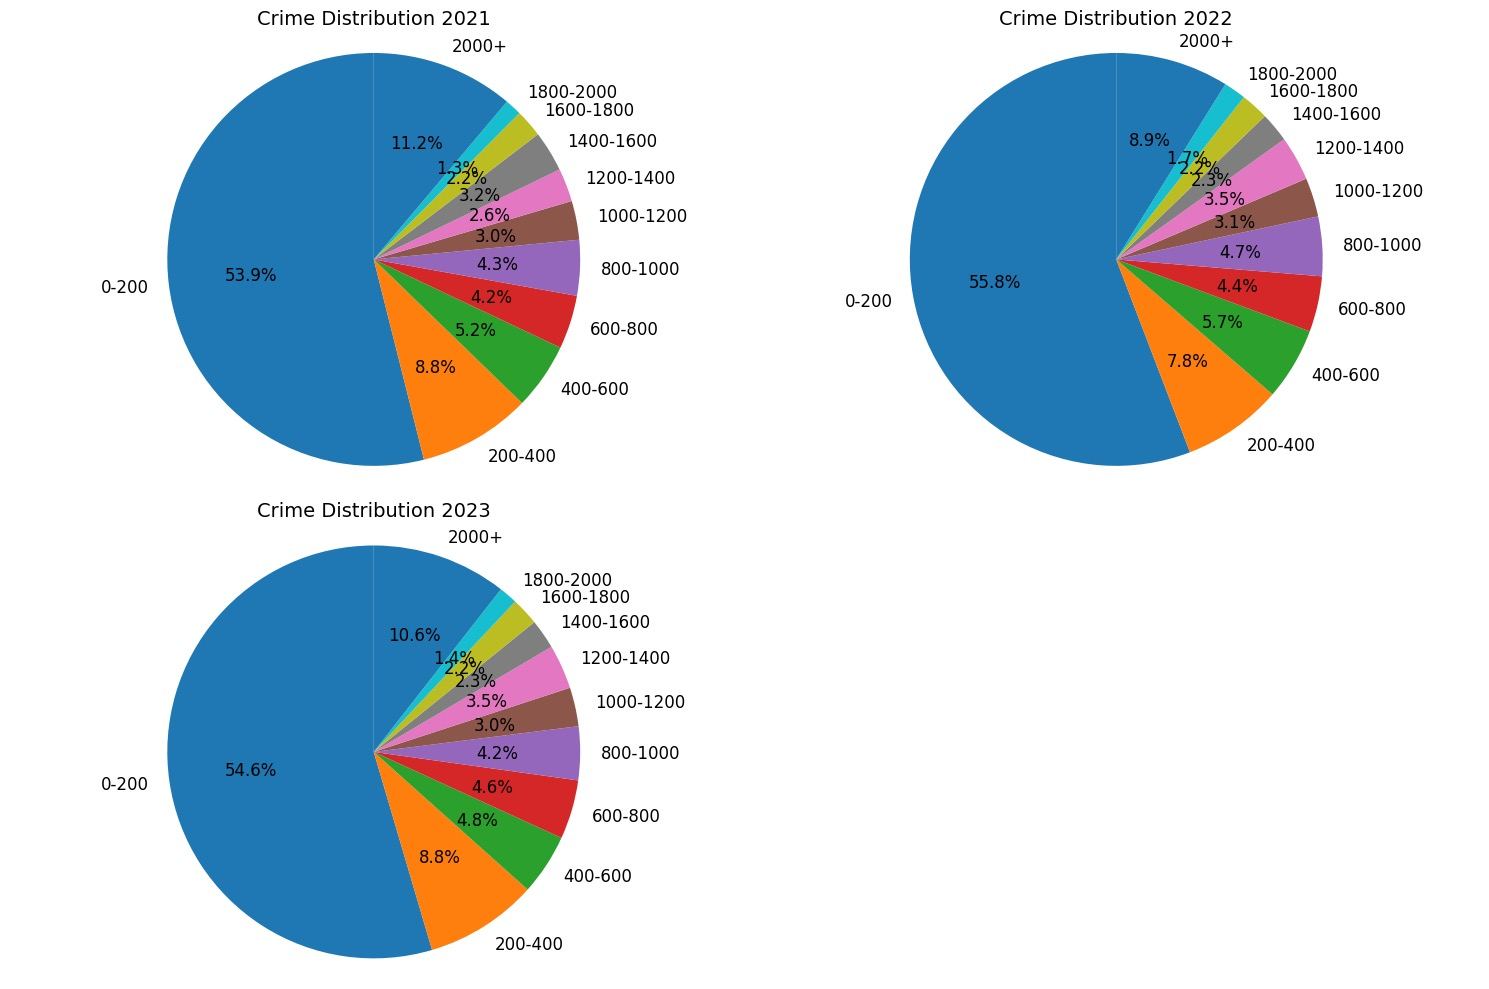

In [5]:
from IPython.display import Image

Image("plots/crime count.png")

Finally, we combine the property data with all the externel features together for modeling and prediction.

# Modeling and results

## 1. What are the most important internal and external features in predicting rental prices? 

- Internal features: beds, baths, parking

- External features: People's weekly Income, latest price information, the time cost on cbd.


To prepare the dataset for machine learning model training, missing values were addressed, and key features such as bedrooms, bathrooms, parking spaces, and postal codes were extracted. Numeric features were converted and cleaned to ensure the data was ready for the training process.

We get the conclusion from the follwing graphs: Random Foresdt feature importance and XGBoost feature importance 

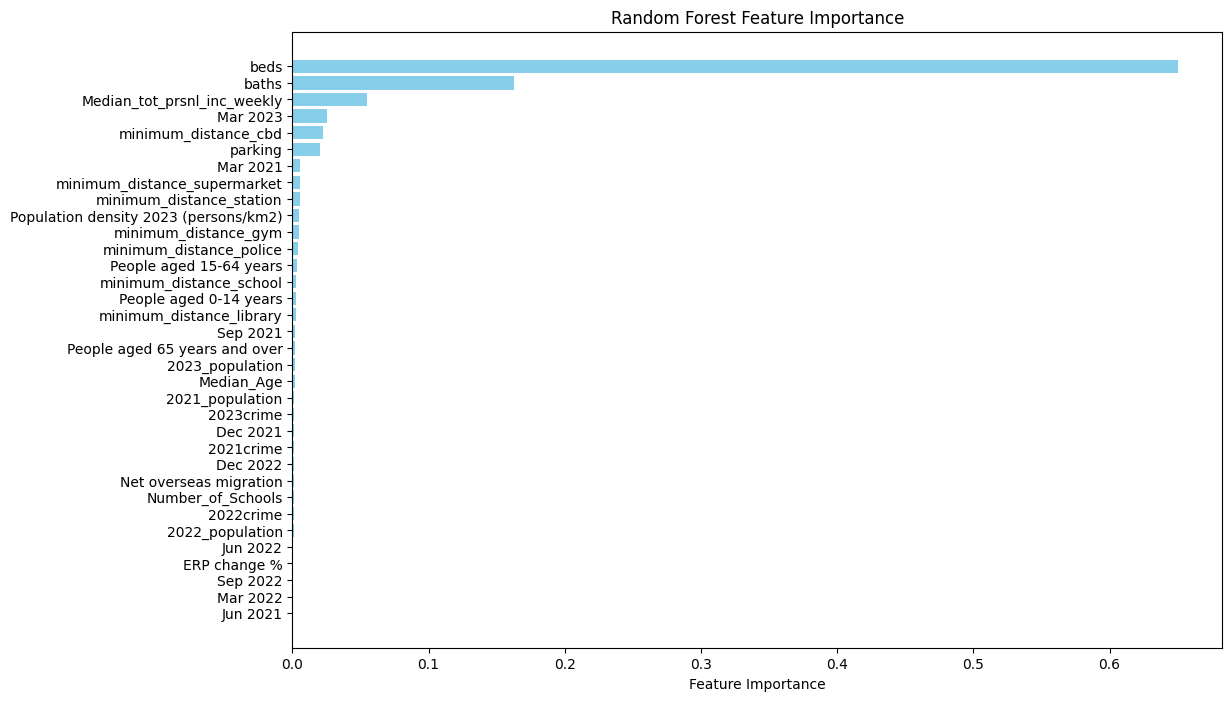

In [7]:
from IPython.display import Image

Image("plots/rf_importance.png")

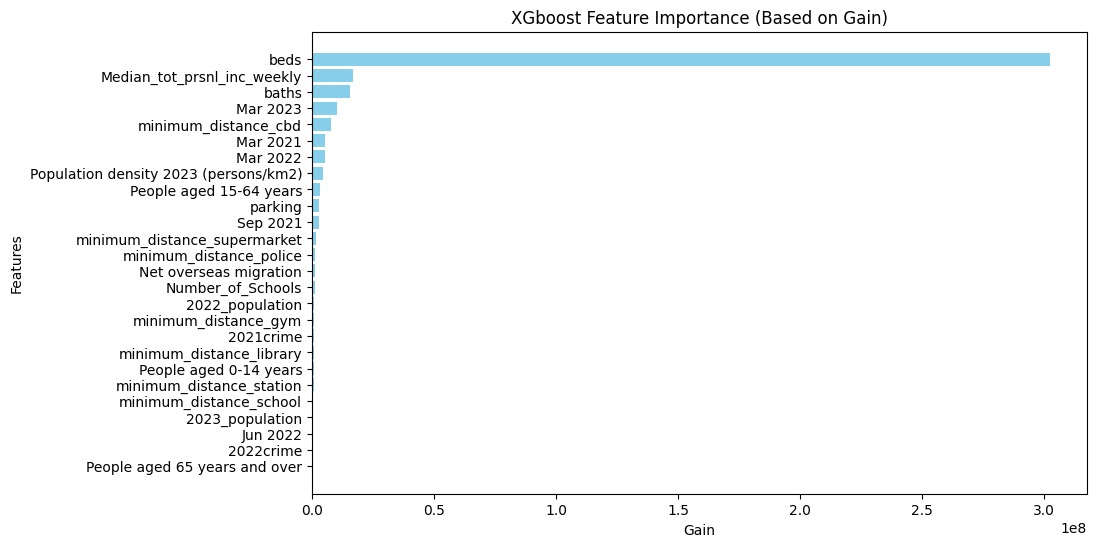

In [8]:
Image("plots/xg_importance.png")

## 2. What are the top 10 suburbs with the highest predicted growth rate?


- Ballarat, 3350
- Dandenong, 3175
- Werribee, 3030
- Hoppers Crossing, 3029
- Bendigo, 3550
- Frankston, 3199
- Cranbourne, 3977
- Shepparton, 3630
- St Albans, 3021
- Craigieburn, 3064


Our model generate the 5-year prediction then we calculate each year's growth rate then select the rapid ones in 3-year.

Following is how each location appears on the map

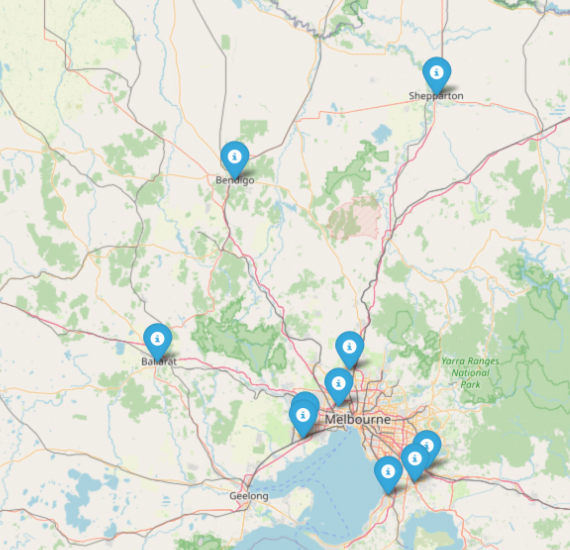

In [10]:
Image("plots/TOP10 suburb.png")

### Models

We used ARIMA(AutoRegressive Integrated Moving Average), ARIMA with linear regression, random forest,XGboost and Support vector regression.

- ARIMA: used time as the feature to predict the average property price in the suburb.
It assumes that the timeline has the linear relationship, good for the short term prediction, long-term prediction caused error. The results show the increased tendency. The AIC and BIC values are small, the data fits our model well since it is very simple.

- ARIMA with linear regression: depending on the ARIMA is too simple so we add the features of crime and population to predict, but  the results are worse than the previous ones.

- SVR: it is suit for non-linear realstionship and high-dimensional data. 
    - Training set : R²:0.1393. Test set :MSE:87556.9567, RMSE:295.9002, MAE: 129.4764, R²: 0.3865. 
    - Although we alread adjusted the hyperparameters in SVR, the results still bad. Both training and testing set's R sqaure is low and high MSE, RMSE values. The poor reuslts may depends on the outlier's affection.

- Random forest: it can be used for both classification and regression problems, it also can calculate the importance of the features. 
    - Training set : R²: 0.8421. Test set: MSE:68556.8708, RMSE:261.8337, MAE: 115.7222, R²: 0.5196. 
    - Overall, the R square of test set is lower than the training set, the model may has overfitting problems. The value of MSE and RMSE are high which shows the model has large errors. The model is lack of generalisation.


- XGboost: it is a supervised learning including the method of classification, regression, and ranking problems which is powerful for our tasks. For prediction we create characteristic data for the next five years. The output result and modeling score are better than the previous ones. 
    - Training set : R²: 0.9822. Test set: MSE: 64239.4907, RMSE: 253.4551, MAE: 114.1430, R²: 0.5499. 
    - The R square of test set is lower than the training set, the model may learn the outlier's pattern. The high MSE and RMSE also shows that the model is influenced by the extreme values.



Although SVM predictions show similar trends, XGBoost typically performs better when dealing with non-linear data, so growth rate analysis suggests primarily relying on XGBoost.

## 3. What are the most liveable and affordable suburbs according to your chosen metrics?

Affordability:

- South Yarra: 0.998208
- Geelong: 0.997447
- Ballarat: 0.997072
- Port Melbourne: 0.996916
- Melbourne: 0.996350

These suburbs score high on `livability_score`, indicating superior living conditions and possibly good
community facilities and environmental quality.

Livability: 
- South Melbourne: 0.346525
- Melbourne: 0.345527
- Geelong: 0.339952
- Craigieburn: 0.332845
- Box Hill: 0.285335

These suburbs score high on `affordability_score`, indicating that the rent or housing prices in these areas are
relatively affordable and are economically viable choices.

This is the formula of calculation:

$$
\text{livability score} = \frac{\sum_{i=1}^{n} \left( \text{standardized distance}_i \times \text{weight}_i \right) + \text{crime score} \times 0.25}{\sum_{i=1}^{n} \text{weight}_i + 1}
$$

$$
\text{affordability score}=1−\text{standardized affordability ratio}
$$
$$
\text{combined score} = 0.5 × \text{livability score} + 0.5 × \text{affordability score}

$$

The weight value is referenced to the The Economist Intelligence Unit
http://chinese.seoul.go.kr/gtk/gcs/download/R46_Maturity%20of%20Community%20(Liveability%20ranking%20and%20overview_Feb%202013).pdf

The affordable is assumed 30% of the weekly income which is referenced from International Housing Association. https://www.internationalhousingassociation.org/fileUpload_details.aspx?contentTypeID=3&contentID=254954&subContentID=725161&channelID=38488

Also, cannot find the propertion of liveability and affordability so we choose weighted 0.5 of each.

The following table shows the combine score of the top 10 suburbs:

In [12]:
import pandas as pd 
data = pd.read_csv('data/curated/external/combine_score.csv')
results = data.sort_values(by='combined_score', ascending=False)
results.iloc[0:10]

Unnamed: 0           Suburb  livability_score  affordability_score  \
0         135        Melbourne          0.345525             0.996350   
1         972  South Melbourne          0.346523             0.994969   
2         879          Geelong          0.339950             0.997447   
3        5449      Craigieburn          0.332844             0.994827   
4        2943      South Yarra          0.287723             0.998208   
5        5290   Port Melbourne          0.281201             0.996916   
6        1917           Coburg          0.282976             0.994323   
7        1508     Malvern East          0.283332             0.993691   
8        1145         Ballarat          0.279663             0.997072   
9        2440         Box Hill          0.285333             0.990837   

   combined_score  
0        0.670938  
1        0.670746  
2        0.668699  
3        0.663835  
4        0.642965  
5        0.639058  
6        0.638650  
7        0.638512  
8        0.638368  
9        0.638085

# Limitation

- postcode: some inconsistencies in abbreviations and capitalization for each dataset, which can only be manually corrected.
- the crime rate in CBD:  is too high, which can affect the accuracy of the model when used. 
- population data: it only covers permanent residents and does not take into account important groups such as international students.
- price: the price in the different various format, when converting to the weekly price it may contain some outliers which may affect the accuracy of the model when used.
- models: the value of R sqaure are not good although we have already adjusted the model's parameters, may investiagte more models in future.


# Recommdation

- the company prioritize investing in those suburbs with rapid population growth and high community safety.
- plan offering subscription-based access to these reports that people can provide real estate investors, landlords, and developers with valuable predictions on rental market trends and help them avoid unstable market risks.

This will enable clients to make informed investment decisions and identify high-return opportunities.
